# Data exploration

We use the h5 (skeleton.h5 and ir_skeleton.h5) datasets created from our NTU RGB+D depo. Make sure to place them inside data/processed/ folder along with the "samples_names.txt" folder.

The aim of this notebook is to explore our inputs (data from skeleton.h5) and our output (ir_skeleton.h5), how to extract them and convert them to the PyTorch format.

In [1]:
%matplotlib notebook
import h5py
import os
import random
import sys
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch import nn

# Custom imports
from torch_dataset import *
from train_utils import *

# Moves back one folder to use module from src folder
sys.path.insert(0, os.getcwd() + '/../')

# Global variables (change to your settings)
h5_dataset_path = os.getcwd() + "/../data/processed/"
skeleton_h5_name = "skeleton.h5"
ir_skeleton_h5_name = "ir_skeleton.h5"
samples_names_file = "samples_names.txt"

batch_size = 64


## 1. Open h5 datasets and extract a random sample

In [2]:
# Sample names in a list (total of 56880 samples)
samples_names_list = [line.rstrip('\n') for line in open(h5_dataset_path + samples_names_file)]

# Shuffle samples_names_list 
random.shuffle(samples_names_list)

# Take first random sample
sample_name = samples_names_list[0]

# Open skeleton dataset
skeleton_3d_h5 = h5py.File(h5_dataset_path + skeleton_h5_name, 'r')
skeleton_2d_h5 = h5py.File(h5_dataset_path + ir_skeleton_h5_name, 'r')

# Get sample 
skeleton_3d = skeleton_3d_h5[sample_name]["skeleton"][:] # shape (3, max_frame, n_joints = 25, n_subjects = 2)
skeleton_2d = skeleton_2d_h5[sample_name]["ir_skeleton"][:] # shape (2, max_frame, n_joints = 25, n_subjects = 2)

# Close datasets
skeleton_3d_h5.close()
skeleton_2d_h5.close()

## 2. Create custom PyTorch datasets and data loaders

### 2.1. Split samples into train and test (50-50) and create corresponding PyTorch datasets

We do not use a validation set. While technically this would be the best way of going about it, the problem is easy enough to consider that our model generalizes well. Additionally, the training sample is a random joint for a random frame. This means the training already acts as a validation set because it is very unlikely that two identical points will be studied.

In [3]:
train_samples_list = samples_names_list[:len(samples_names_list)//2]
# train_samples_list = samples_names_list[:1000]
test_samples_list = samples_names_list[len(samples_names_list)//2:]
# test_samples_list = samples_names_list[5000:10000]

train_dataset = TorchDataset(h5_dataset_path, train_samples_list)
test_dataset = TorchDataset(h5_dataset_path, test_samples_list)


## 2.2 Create data loaders

In [4]:
# Create train dataloader
train_generator = data.DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  pin_memory=True,
                                  num_workers=4)

test_generator = data.DataLoader(test_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 pin_memory=True,
                                 num_workers=4)

## 3. Create model

In [5]:
model = nn.Sequential(
    nn.Linear(3, 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 2)
)
model.to(device)

Sequential(
  (0): Linear(in_features=3, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=2, bias=True)
)

## 4. Evaluate performances

### 4.1 Train model and save every epoch

In [6]:
model, time_batch, loss_batch, time_epoch, loss_epoch = train_model(model=model, 
                                                                    optimizer="ADAM",
                                                                    learning_rate=1e-2,
                                                                    weight_decay=0, 
                                                                    gradient_threshold=1,
                                                                    epochs=5, 
                                                                    accumulation_steps=1,
                                                                    output_folder=os.getcwd() + "/",
                                                                    train_generator=train_generator)

Epoch : 1 / 5 ...
Epoch : 2 / 5 ...
Epoch : 3 / 5 ...
Epoch : 4 / 5 ...
Epoch : 5 / 5 ...


### 4.2 Plot loss (MSE)

<IPython.core.display.Javascript object>


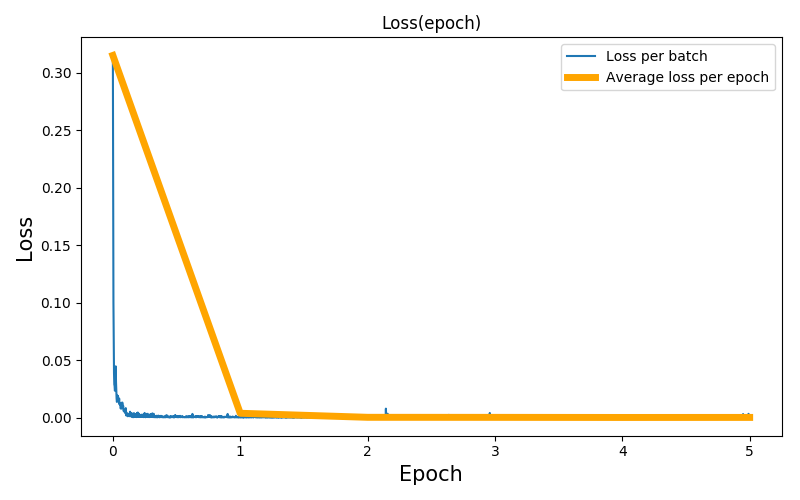

In [7]:
# Plot loss 
fig = plt.figure()
fig.set_size_inches(8, 5)
ax = fig.add_subplot(1, 1, 1)

ax.plot(time_batch, loss_batch)
ax.plot(time_epoch, [loss_batch[0]] + loss_epoch, color="orange", linewidth=5)
ax.legend(["Loss per batch", "Average loss per epoch"])
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.title("Loss(epoch)")

plt.tight_layout()
plt.show()



### 4.3. Evaluate performances on test set

In [8]:
eval_test_set(model, test_generator)

Batch : 0 / 445
Random point prediction :
-> True : (322, 252)
-> Pred : (314, 243)
-> Loss : 0.0030962449964135885

Batch : 10 / 445
Random point prediction :
-> True : (291, 158)
-> Pred : (301, 145)
-> Loss : 0.0002345659740967676

Batch : 20 / 445
Random point prediction :
-> True : (261, 218)
-> Pred : (263, 211)
-> Loss : 0.0029710878152400255

Batch : 30 / 445
Random point prediction :
-> True : (301, 217)
-> Pred : (301, 215)
-> Loss : 0.0030131638050079346

Batch : 40 / 445
Random point prediction :
-> True : (281, 213)
-> Pred : (280, 207)
-> Loss : 0.00022105431708041579

Batch : 50 / 445
Random point prediction :
-> True : (243, 129)
-> Pred : (245, 117)
-> Loss : 0.00018277272465638816

Batch : 60 / 445
Random point prediction :
-> True : (225, 144)
-> Pred : (226, 134)
-> Loss : 0.0002505934389773756

Batch : 70 / 445
Random point prediction :
-> True : (236, 265)
-> Pred : (236, 259)
-> Loss : 0.00017390861466992646

Batch : 80 / 445
Random point prediction :
-> True : (